In [ ]:
# [셀 1] 필수 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.ticker as mtick
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt


# 윈도우 기준 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("✅ 한글 폰트 설정 완료")

# 데이터 로드
df = pd.read_csv('./dataset/IMDB Dataset.csv')
print("--- 1. 데이터 로드 완료 ---")
print(f"전체 데이터 개수: {len(df)}")

c:\code\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


✅ 한글 폰트 설정 완료
--- 1. 데이터 로드 완료 ---
전체 데이터 개수: 50000


In [ ]:
# [셀 2] 컬럼명 및 데이터 상위 5개 확인
print("데이터 형태:", df.shape)

print("\n--- 2. 컬럼명 확인 ---")
print(df.columns)
print("\n컬럼명:", df.columns.tolist())

print("\n--- 3. 상위 5개 내용 확인 ---")
display(df.head())


--- 2. 컬럼명 확인 ---
Index(['review', 'sentiment'], dtype='object')

--- 3. 상위 5개 내용 확인 ---
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
# [셀 3] 전처리 및 원핫인코딩 (Sentiment: positive/negative를 1/0으로)
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment']) # positive: 1, negative: 0

print("\n--- 4. 라벨 인코딩 완료 (상위 5개) ---")
print(df[['review', 'sentiment']].head())


--- 4. 라벨 인코딩 완료 (상위 5개) ---
                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


In [4]:
# [셀 4] 시각화 (그래프 5개 이상)
print("\n--- 5. 데이터 시각화 ---")
plt.figure(figsize=(20, 40))
# 15×10 크기의 그래프를 만들꺼야


--- 5. 데이터 시각화 ---


<Figure size 2000x4000 with 0 Axes>

<Figure size 2000x4000 with 0 Axes>

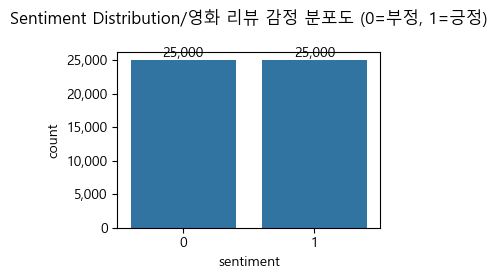

In [ ]:
# 위 그래프를 실제로 그리는 부분 
# 1. 감정 분포 (카운트 플롯)

plt.subplot(2, 2, 1) #2행2열짜리 공간에 1번째칸에 이 그래프를 그릴거야
ax = sns.countplot(x='sentiment', data=df) #sentiment 컬럼에 각 값이 몇 개씩 있는지 세어 막대그래프로 보여줘


# y축 천 단위 쉼표
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title("Sentiment Distribution/영화 리뷰 감정 분포도 (0=부정, 1=긍정)", 
          pad=20
          )

# 막대 위에 숫자 표시
for p in ax.patches:
  ax.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )
  
# 본 그래프는 IMDB 영화 리뷰 데이터셋에 포함된 리뷰들의
# 긍정/부정 감정 분포를 나타낸 것으로,
# 데이터의 클래스 균형 여부를 확인하기 위해 사용되었다.
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Review Length Distribution')

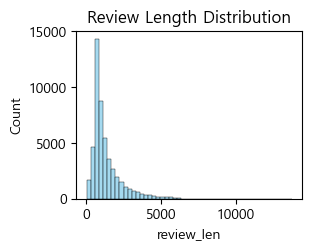

In [ ]:
# 2. 리뷰 길이 분포
df['review_len'] = df['review'].apply(len)
plt.subplot(2, 2, 2)
sns.histplot(df['review_len'], bins=50, color='blue')
plt.title("Review Length Distribution")

# 리뷰 길이 분포 분석을 통해
# 대부분의 리뷰가 특정 길이 범위 내에 분포함을 확인하였다.
# 이를 기반으로 딥러닝 모델의 입력 길이(maxlen)를 합리적으로 설정

Text(0.5, 1.0, 'Word Count by Sentiment')

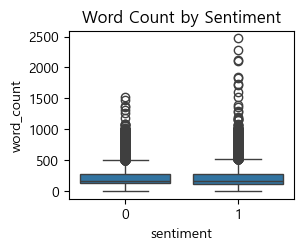

In [7]:
# 3. 단어 개수 확인 (박스플롯)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
plt.subplot(2, 2, 3)
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title("Word Count by Sentiment")

# 그러면 박스플롯 분석 결과, 긍정리뷰일수록 길고 단어를 다양하게 사용할 가능성을 시사한다.

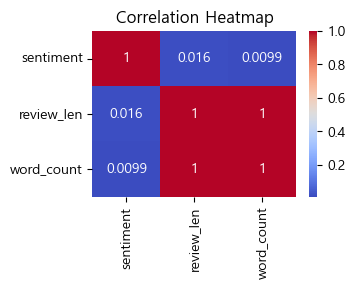

EDA 시각화 완료


[]

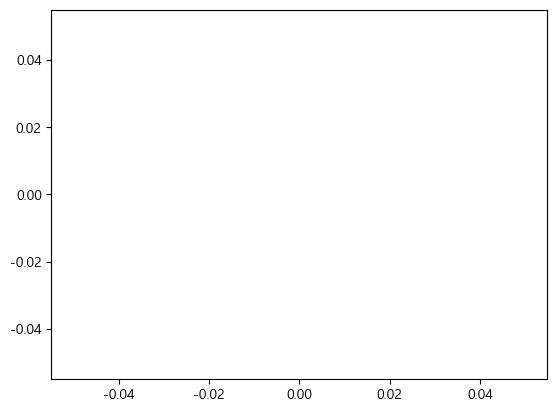

In [ ]:
# 4. 상관관계 히트맵 (수치형 컬럼 기준)
plt.subplot(2, 2, 4)
sns.heatmap(df[['sentiment', 'review_len', 'word_count']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
# Correlation(상관관계) Heatmap(히트맵-데이터끼리의 밀접관계)

plt.tight_layout()
plt.show()
# 파랑: 상관관계약함, 빨강: 상관관계 강함
# 상관관계 분석 결과,
# 리뷰 길이 및 단어 수와 감정 레이블 간의 상관계수는 0에 가까워
# 단순한 수치 정보만으로 감정을 예측하기 어렵다는 점을 확인하였다.
# 이에 따라 텍스트 의미를 반영하는 딥러닝 모델이 필요함을 알 수 있다.
print("EDA 시각화 완료")
# EDA Exploratory Data Analysis 탐색적 데이터 분석으로 

In [9]:
# [셀 5] 텍스트 토큰화 및 패딩 (X, Y 지정)
max_words = 10000 # 가장 많이 사용되는 단어 10,000개만 사용 / 희귀한 단어 제거하고 학습의 안정성을 높임.
max_len = 200    # 리뷰 길이를 200단어로 맞춤 / 데이터 통일화

tokenizer = Tokenizer(num_words=max_words) #단어-> 숫자로 바꿔주는 사전 생성기
tokenizer.fit_on_texts(df['review']) #전체 리뷰를 읽고 어떤 단어가 있는지 얼마나 자주 나오는지 학습
sequences = tokenizer.texts_to_sequences(df['review']) #각 단어를 숫자로 변환

X = pad_sequences(sequences, maxlen=max_len) #숫자로 변환한 단어와 그 리뷰길이(최대 200)
y = df['sentiment'].values
# 여기서부터 딥러닝을 위한 데이터 변환단계/ 딥러닝용 X, Y 전처리 코드
# 텍스트(문장)를 → 숫자 배열로 변환해서 → 딥러닝 입력(X)과 정답(y)을 만듬

In [10]:
# 나중을 위해 토크나이저 저장(스트림/그라디오때 같은 규칙을 써야하는데 그 규칙.(단어 → 숫자 변환))
joblib.dump(tokenizer, 'imdb_tokenizer.pkl') #(LLM/딥러닝에서 불러서씀)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #학습/테스트 데이터 분리

print("\n--- 6. 데이터 분할 완료 ---")
print(f"학습 데이터 형태: {X_train.shape}") #X_train.shape: 리뷰 4만개, 최대 200단어길이

# 학습 준비 + 재사용을 위한 저장 + 데이터 분할


--- 6. 데이터 분할 완료 ---
학습 데이터 형태: (40000, 200)


In [11]:
# [셀 6] 딥러닝 모델 설계 및 학습 (LSTM 사용-> 문맥이해 용도)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, 128, input_length=max_len), #단어의미 학습 레이어
    # 단어번호 -> 의미 벡터로 변환 및 단어 간 의미 관계 자동 학습(오직 딥러닝에서만 가능!)
    
    tf.keras.layers.LSTM(64), #LSTM레이어 단어개수 세기 및 문장의미 이해
    
    tf.keras.layers.Dense(32, activation='relu'), #Dense(은닉층) 문맥정보를 요약.
    tf.keras.layers.Dense(1, activation='sigmoid') #출력층 / 결과를 0~1확률로 출력
])

# LSTM: 시계열 데이터나 순차 데이터를 다루는 다양한 분야에서 사용.
# 자연어(번역, 텍스트 생성, 감성분석), 음성 인식, 비디오 분석, 시계열 예측(주가, 날씨 등)
# 트랜스포머 모델이 낳은 분야에서 LSTM을 대체하고있음. 한마디로 트랜스 포머와는 다른것

c:\code\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# 문제를 푸는 방법과 
model.compile(
    loss='binary_crossentropy', #정답과 예측의 차이(오차)를 계산하는 공식
    optimizer='adam', #모델이 학습할떄 정답을 찾아가도록 조절해주는 길잡이역할
    metrics=['accuracy'] #성능평가 기준, 맞춘비율
)

print("\n--- 7. 모델 학습 시작 (최적의 모델 자동 저장) ---")

# 가장 좋은 모델만 저장하는 설정
checkpoint = ModelCheckpoint(
    'imdb_model.h5',      # 저장할 파일 이름
    monitor='val_loss',   # 확인용 오차를 감시
    save_best_only=True,  # 오차가 가장 낮을 때만 저장!
    mode='min',           # 오차는 낮을수록(min) 좋으니까
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=5,             # 전체 학습데이터를 5번 반복해서 학습.
    batch_size=64,      #한번에 64개리뷰씩 처리 / 안정성을 위함
    validation_split=0.1,    #학습데이터의 10%는 공부 안시키고 시험봄.
                                # 문제와 답을 통째로 외워버린게 아닌지검사(과적합)하는 역할
                                # (암세포 여기에서 문제가 있을수도있겠네)
    callbacks=[checkpoint] # 여기에 체크포인트를 넣어주세요!
)


--- 7. 모델 학습 시작 (최적의 모델 자동 저장) ---
Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7425 - loss: 0.4848
Epoch 1: val_loss improved from None to 0.33846, saving model to imdb_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 62s 105ms/step - accuracy: 0.8209 - loss: 0.3899 - val_accuracy: 0.8543 - val_loss: 0.3385
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9058 - loss: 0.2410
Epoch 2: val_loss did not improve from 0.33846
563/563 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.9078 - loss: 0.2349 - val_accuracy: 0.8830 - val_loss: 0.3583
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9347 - loss: 0.1783
Epoch 3: val_loss improved from 0.33846 to 0.31973, saving model to imdb_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.9336 - loss: 0.1769 - val_accuracy: 0.8622 - val_loss: 0.3197
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9574 - loss: 0.1216 
Epoch 4: val_loss did not improve from 0.31973
563/563 ━━━━━━━━━━━━━━━━━━━━ 58s 103ms/step - accuracy: 0.9534 - loss: 0.1262 - val_accuracy: 0.8770 - val_loss: 0.3329
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9695 - loss: 0.0897
Epoch 5: val_loss did not improve from 0.31973
563/563 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.9662 - loss: 0.0955 - val_accuracy: 0.8648 - val_loss: 0.4087


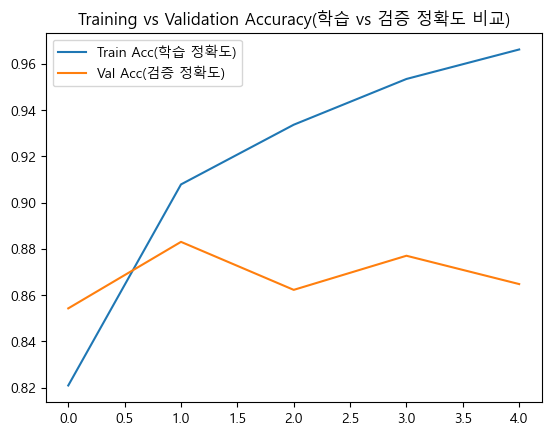

학습정확도는 올라가지만 검증정확도는 그렇지 않음. 따라서 과적합이 시각적으로 증명이 됨.


In [16]:
# 학습곡선 그래프(과적합 시각적 증명)

plt.plot(history.history['accuracy'], label='Train Acc(학습 정확도)')
plt.plot(history.history['val_accuracy'], label='Val Acc(검증 정확도)')
plt.legend()
plt.title("Training vs Validation Accuracy(학습 vs 검증 정확도 비교)")
plt.show()
print("학습정확도는 올라가지만 검증정확도는 그렇지 않음. 따라서 과적합이 시각적으로 증명이 됨.")

In [ ]:
# 테스트 데이터 성능평가

test_loss, test_acc = model.evaluate(X_test, y_test)
# 한번도 사용하지 않았던 데이터 모델에게 풀어보라고 시키는 함수

print(f"테스트 정확도: {test_acc:.4f}")
# test_acc : 테스트 정확도 소숫점 4자리까지표기해.
# 몇번 계산했는지, accuracy: 10,000개중에 몇개를 맞췄는지.

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8686 - loss: 0.3823
테스트 정확도: 0.8686


In [ ]:
# [셀 7] 랜덤 테스트 및 모델 저장
model.save('imdb_model.h5')
print("\n--- 8. 모델 저장 완료: imdb_model.h5 ---")

test_review = ["This movie was absolutely wonderful and amazing!"]
test_seq = tokenizer.texts_to_sequences(test_review)
test_pad = pad_sequences(test_seq, maxlen=max_len)
pred = model.predict(test_pad)
print(f"테스트 문장 예측 결과: {pred[0][0]:.4f}")

# Y리포트
profile = ProfileReport(df, title="IMDB Sentiment Report", explorative=True)
profile



--- 8. 모델 저장 완료: imdb_model.h5 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
테스트 문장 예측 결과: 0.9778
